In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier

In [2]:
pd.set_option('expand_frame_repr', True)
pd.set_option("display.max_rows", 999)
pd.set_option('max_colwidth',100)

## TASK 1

In [3]:
df = pd.read_csv('Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
def check_df(dataframe, head=8):
  print("##### Shape #####")
  print(dataframe.shape)
  print("\n##### Types #####")
  print(dataframe.dtypes)
  print("\n##### Tail #####")
  print(dataframe.tail(head))
  print("\n##### Head #####")
  print(dataframe.head(head))
  print("\n##### Null Analysis #####")
  print(dataframe.isnull().sum())
  print("\n##### Quantiles #####")
  print(dataframe.describe([0,0.05, 0.50, 0.95, 0.99, 1]).T)

In [5]:
check_df(df)

##### Shape #####
(7043, 21)

##### Types #####
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

##### Tail #####
      customerID  gender  SeniorCitizen Partner Dependents  tenure  \
7035  8456-QDAVC    Male              0      No         No      19   
7036  7750-EYXWZ  Female              0      No         No      12   
7037  2569-WGERO  Female              0      No         No      72   
7038  6840-RESVB    Male              0     Yes     

In [6]:
df['OnlineSecurity'].head(20)

0                      No
1                     Yes
2                     Yes
3                     Yes
4                      No
5                      No
6                      No
7                     Yes
8                      No
9                     Yes
10                    Yes
11    No internet service
12                     No
13                     No
14                    Yes
15                    Yes
16    No internet service
17                    Yes
18                     No
19                     No
Name: OnlineSecurity, dtype: object

In [7]:
df.columns = [col.upper() for col in df.columns]

In [8]:
hidden_nan_index = df[df['TOTALCHARGES'].str.contains(' ', case=True, flags=0, na=None, regex=True)].index
hidden_nan_index

Int64Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')

In [9]:
df['TOTALCHARGES'].replace({' ':np.nan}, inplace=True)

In [10]:
df['TOTALCHARGES'].head()

0      29.85
1     1889.5
2     108.15
3    1840.75
4     151.65
Name: TOTALCHARGES, dtype: object

In [11]:
df['TOTALCHARGES'][df['TOTALCHARGES'].isnull() == True]

488     NaN
753     NaN
936     NaN
1082    NaN
1340    NaN
3331    NaN
3826    NaN
4380    NaN
5218    NaN
6670    NaN
6754    NaN
Name: TOTALCHARGES, dtype: object

In [12]:
df['TOTALCHARGES'] = pd.to_numeric(df['TOTALCHARGES'])

In [15]:
df['CHURN'] = np.where((df['CHURN'] == 'Yes'), 1, 0).astype(int)

## TASK 2

In [16]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == 'O']

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtype != 'O']

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtype == 'O']

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtype != 'O']

    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [17]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 2


In [18]:
cat_cols

['GENDER',
 'PARTNER',
 'DEPENDENTS',
 'PHONESERVICE',
 'MULTIPLELINES',
 'INTERNETSERVICE',
 'ONLINESECURITY',
 'ONLINEBACKUP',
 'DEVICEPROTECTION',
 'TECHSUPPORT',
 'STREAMINGTV',
 'STREAMINGMOVIES',
 'CONTRACT',
 'PAPERLESSBILLING',
 'PAYMENTMETHOD',
 'SENIORCITIZEN',
 'CHURN']

In [19]:
num_cols

['TENURE', 'MONTHLYCHARGES', 'TOTALCHARGES']

In [20]:
cat_but_car

['CUSTOMERID']

## TASK 3

In [21]:
def num_summary(dataframe, num_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[num_col].describe(quantiles).T)
    if plot:
        dataframe[num_col].hist()
        plt.xlabel(num_col)
        plt.title(num_col)
        plt.show(block=True)

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
5%          1.000000
10%         2.000000
20%         6.000000
30%        12.000000
40%        20.000000
50%        29.000000
60%        40.000000
70%        50.000000
80%        60.000000
90%        69.000000
95%        72.000000
99%        72.000000
max        72.000000
Name: TENURE, dtype: float64


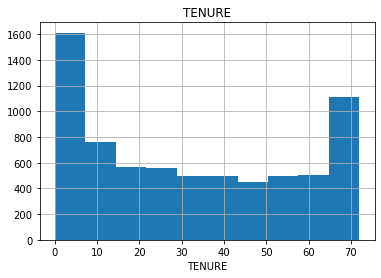

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
5%         19.650000
10%        20.050000
20%        25.050000
30%        45.850000
40%        58.830000
50%        70.350000
60%        79.100000
70%        85.500000
80%        94.250000
90%       102.600000
95%       107.400000
99%       114.729000
max       118.750000
Name: MONTHLYCHARGES, dtype: float64


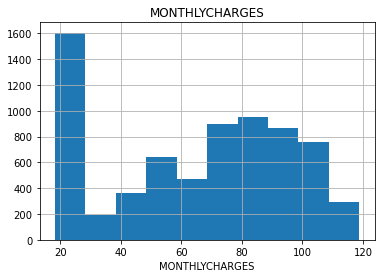

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
5%         49.605000
10%        84.600000
20%       267.070000
30%       551.995000
40%       944.170000
50%      1397.475000
60%      2048.950000
70%      3141.130000
80%      4475.410000
90%      5976.640000
95%      6923.590000
99%      8039.883000
max      8684.800000
Name: TOTALCHARGES, dtype: float64


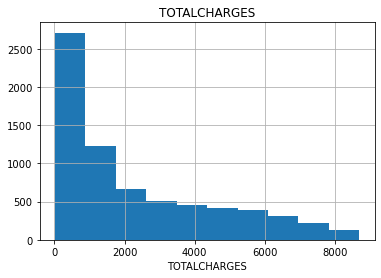

In [22]:
for col in num_cols:
    num_summary(df, col, True)

In [23]:
def cat_summary(dataframe, cat_col, plot=False):
    print(pd.DataFrame({cat_col: dataframe[cat_col].value_counts(),
                        "Ratio": 100 * dataframe[cat_col].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[cat_col], data=dataframe)
        plt.show(block=True)

        GENDER     Ratio
Male      3555  50.47565
Female    3488  49.52435
##########################################


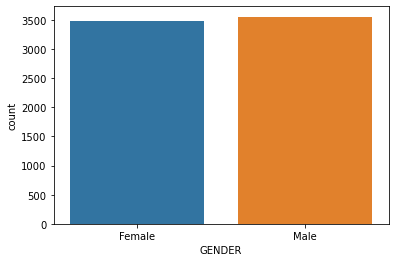

     PARTNER     Ratio
No      3641  51.69672
Yes     3402  48.30328
##########################################


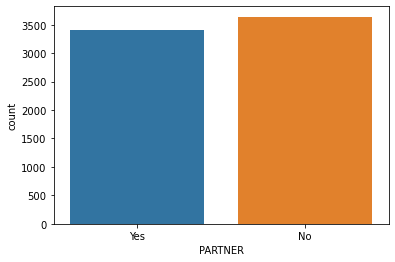

     DEPENDENTS      Ratio
No         4933  70.041176
Yes        2110  29.958824
##########################################


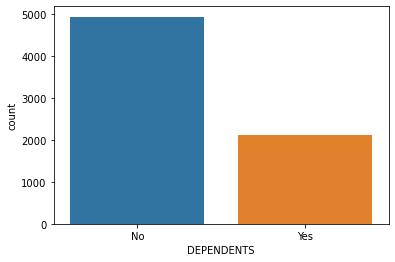

     PHONESERVICE      Ratio
Yes          6361  90.316626
No            682   9.683374
##########################################


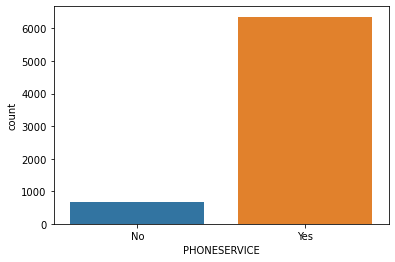

                  MULTIPLELINES      Ratio
No                         3390  48.132898
Yes                        2971  42.183729
No phone service            682   9.683374
##########################################


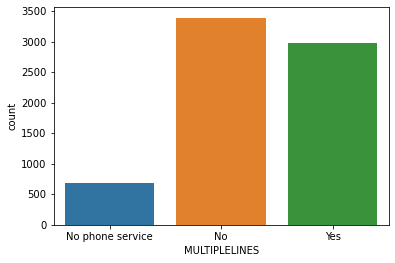

             INTERNETSERVICE      Ratio
Fiber optic             3096  43.958540
DSL                     2421  34.374556
No                      1526  21.666903
##########################################


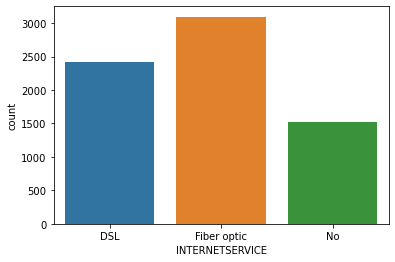

                     ONLINESECURITY      Ratio
No                             3498  49.666335
Yes                            2019  28.666761
No internet service            1526  21.666903
##########################################


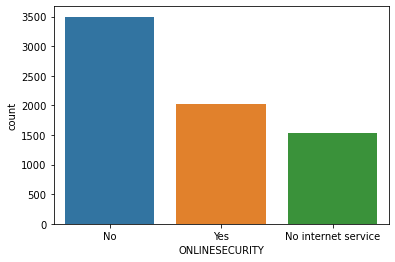

                     ONLINEBACKUP      Ratio
No                           3088  43.844952
Yes                          2429  34.488144
No internet service          1526  21.666903
##########################################


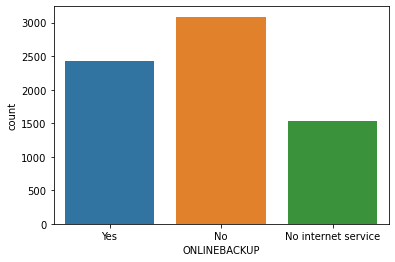

                     DEVICEPROTECTION      Ratio
No                               3095  43.944342
Yes                              2422  34.388755
No internet service              1526  21.666903
##########################################


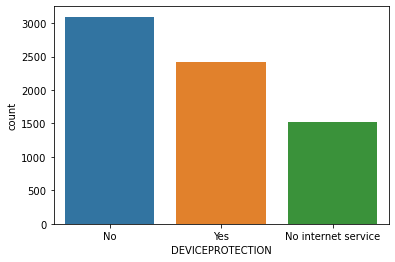

                     TECHSUPPORT      Ratio
No                          3473  49.311373
Yes                         2044  29.021724
No internet service         1526  21.666903
##########################################


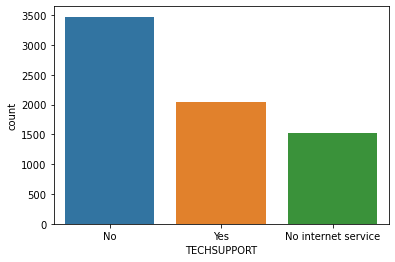

                     STREAMINGTV      Ratio
No                          2810  39.897771
Yes                         2707  38.435326
No internet service         1526  21.666903
##########################################


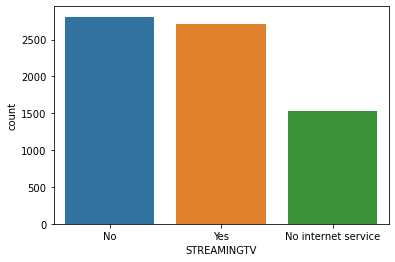

                     STREAMINGMOVIES      Ratio
No                              2785  39.542808
Yes                             2732  38.790288
No internet service             1526  21.666903
##########################################


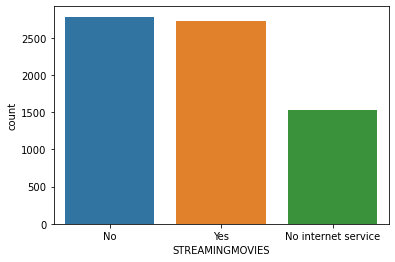

                CONTRACT      Ratio
Month-to-month      3875  55.019168
Two year            1695  24.066449
One year            1473  20.914383
##########################################


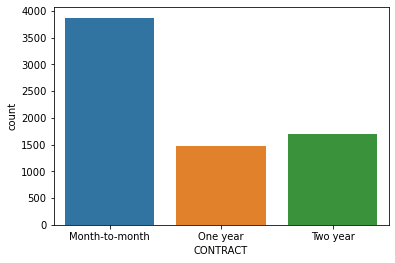

     PAPERLESSBILLING      Ratio
Yes              4171  59.221922
No               2872  40.778078
##########################################


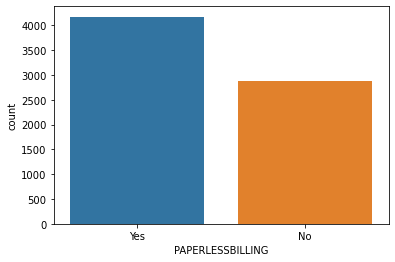

                           PAYMENTMETHOD      Ratio
Electronic check                    2365  33.579441
Mailed check                        1612  22.887974
Bank transfer (automatic)           1544  21.922476
Credit card (automatic)             1522  21.610109
##########################################


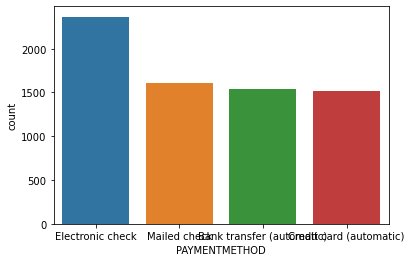

   SENIORCITIZEN      Ratio
0           5901  83.785319
1           1142  16.214681
##########################################


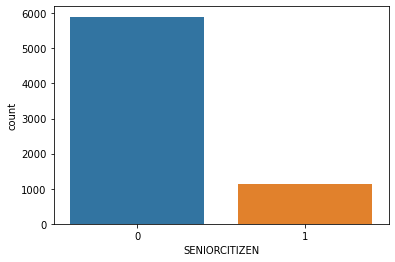

   CHURN  Ratio
0   7043  100.0
##########################################


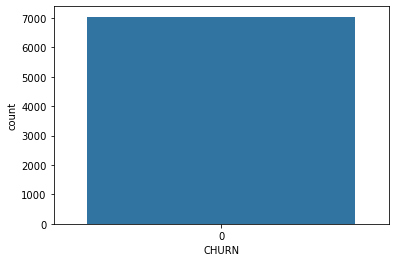

In [24]:
for col in cat_cols:
    cat_summary(df, col, True)

## TASK 4

In [25]:
def target_summary_with_cat(dataframe, target, cat_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(cat_col)[target].mean()}), end="\n\n\n")

In [26]:
def target_summary_with_num(dataframe, target, num_col):
    print(dataframe.groupby(target).agg({num_col: "mean"}), end="\n\n\n")

In [27]:
df.head()

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,...,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0


In [28]:
df.dtypes

CUSTOMERID           object
GENDER               object
SENIORCITIZEN         int64
PARTNER              object
DEPENDENTS           object
TENURE                int64
PHONESERVICE         object
MULTIPLELINES        object
INTERNETSERVICE      object
ONLINESECURITY       object
ONLINEBACKUP         object
DEVICEPROTECTION     object
TECHSUPPORT          object
STREAMINGTV          object
STREAMINGMOVIES      object
CONTRACT             object
PAPERLESSBILLING     object
PAYMENTMETHOD        object
MONTHLYCHARGES      float64
TOTALCHARGES        float64
CHURN                 int32
dtype: object

In [29]:
for col in cat_cols:
    target_summary_with_cat(df, 'CHURN', col)

        TARGET_MEAN
GENDER             
Female          0.0
Male            0.0


         TARGET_MEAN
PARTNER             
No               0.0
Yes              0.0


            TARGET_MEAN
DEPENDENTS             
No                  0.0
Yes                 0.0


              TARGET_MEAN
PHONESERVICE             
No                    0.0
Yes                   0.0


                  TARGET_MEAN
MULTIPLELINES                
No                        0.0
No phone service          0.0
Yes                       0.0


                 TARGET_MEAN
INTERNETSERVICE             
DSL                      0.0
Fiber optic              0.0
No                       0.0


                     TARGET_MEAN
ONLINESECURITY                  
No                           0.0
No internet service          0.0
Yes                          0.0


                     TARGET_MEAN
ONLINEBACKUP                    
No                           0.0
No internet service          0.0
Yes                          0

In [30]:
for col in num_cols:
    target_summary_with_num(df, 'CHURN', col)

          TENURE
CHURN           
0      32.371149


       MONTHLYCHARGES
CHURN                
0           64.761692


       TOTALCHARGES
CHURN              
0       2283.300441




In [31]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 2


## TASK 5

In [32]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [33]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [34]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe,col_name)
    outlier_df = dataframe[(dataframe[col_name] < low) | (dataframe[col_name] > up)]

    if outlier_df.shape[0] > 10:
        print(outlier_df.head())
    else:
        print(outlier_df)

    if index:
        return outlier_df.index

In [35]:
for col in num_cols:
    print(col, check_outlier(df, col))

TENURE False
MONTHLYCHARGES False
TOTALCHARGES False


In [36]:
for col in num_cols:
    print(col, outlier_thresholds(df, col))

TENURE (-60.0, 124.0)
MONTHLYCHARGES (-46.02499999999999, 171.375)
TOTALCHARGES (-4688.481250000001, 8884.66875)


In [37]:
for col in num_cols:
    print(f'\n#####{col}#####')
    print(grab_outliers(df, col))


#####TENURE#####
Empty DataFrame
Columns: [CUSTOMERID, GENDER, SENIORCITIZEN, PARTNER, DEPENDENTS, TENURE, PHONESERVICE, MULTIPLELINES, INTERNETSERVICE, ONLINESECURITY, ONLINEBACKUP, DEVICEPROTECTION, TECHSUPPORT, STREAMINGTV, STREAMINGMOVIES, CONTRACT, PAPERLESSBILLING, PAYMENTMETHOD, MONTHLYCHARGES, TOTALCHARGES, CHURN]
Index: []

[0 rows x 21 columns]
None

#####MONTHLYCHARGES#####
Empty DataFrame
Columns: [CUSTOMERID, GENDER, SENIORCITIZEN, PARTNER, DEPENDENTS, TENURE, PHONESERVICE, MULTIPLELINES, INTERNETSERVICE, ONLINESECURITY, ONLINEBACKUP, DEVICEPROTECTION, TECHSUPPORT, STREAMINGTV, STREAMINGMOVIES, CONTRACT, PAPERLESSBILLING, PAYMENTMETHOD, MONTHLYCHARGES, TOTALCHARGES, CHURN]
Index: []

[0 rows x 21 columns]
None

#####TOTALCHARGES#####
Empty DataFrame
Columns: [CUSTOMERID, GENDER, SENIORCITIZEN, PARTNER, DEPENDENTS, TENURE, PHONESERVICE, MULTIPLELINES, INTERNETSERVICE, ONLINESECURITY, ONLINEBACKUP, DEVICEPROTECTION, TECHSUPPORT, STREAMINGTV, STREAMINGMOVIES, CONTRACT, PAPER

In [38]:
def replace_with_thresholds(dataframe, col_name):
    low, up = outlier_thresholds(dataframe, col_name)

    dataframe.loc[dataframe[col_name] > up, col_name] = up
    dataframe.loc[dataframe[col_name] < low, col_name] = low

In [39]:
for col in num_cols:
    replace_with_thresholds(df, col)

## TASK 6

In [40]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end='\n')

    if na_name:
        return na_columns

In [41]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains('_NA_')].columns
    for col in na_flags:
        print(pd.DataFrame({'TARGET_MEAN': temp_df.groupby(col)[target].mean(),
                            'Count': temp_df.groupby(col)[target].count()}), end='\n\n\n')

In [42]:
missing_values_table(df)

              n_miss  ratio
TOTALCHARGES      11   0.16


In [43]:
df['TOTALCHARGES'].isnull().values.any()

True

In [44]:
missing_vs_target(df, 'CHURN', ['TOTALCHARGES'])

                      TARGET_MEAN  Count
TOTALCHARGES_NA_FLAG                    
0                             0.0   7032
1                             0.0     11




In [45]:
df['CHURN'].value_counts()

0    7043
Name: CHURN, dtype: int64

In [46]:
len(df.columns)

21

## TASK 7

In [47]:
corr = df[num_cols].corr() 
corr

,TENURE,MONTHLYCHARGES,TOTALCHARGES
TENURE,1.00000,0.247900,0.825880
MONTHLYCHARGES,0.24790,1.000000,0.651065
TOTALCHARGES,0.82588,0.651065,1.000000


In [48]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    corr_matrix = corr.abs()
    upper_triangle_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

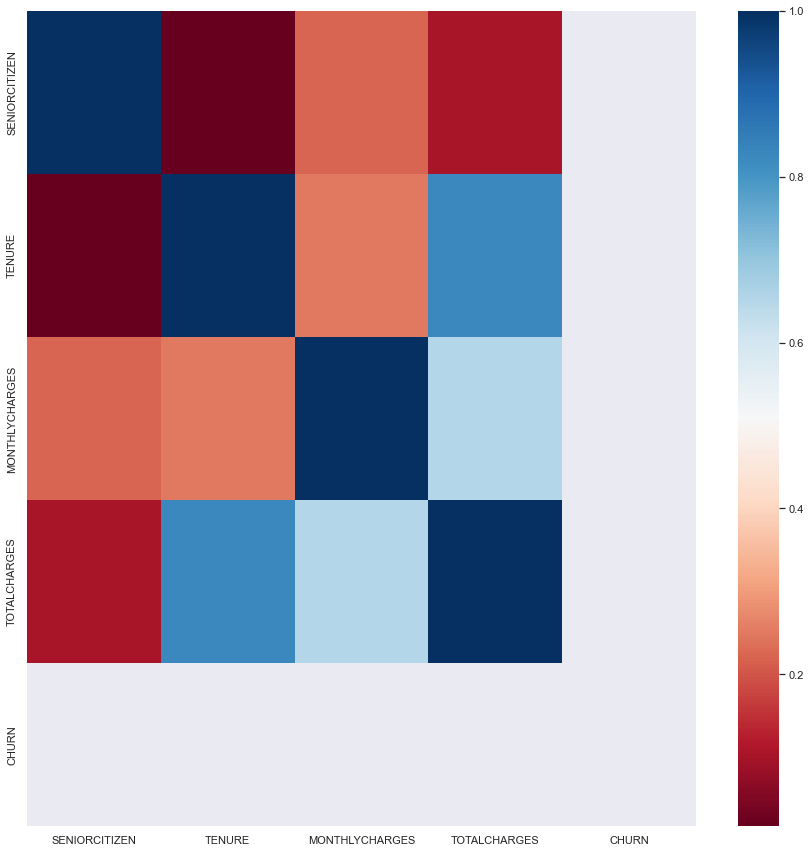

[]

In [49]:
high_correlated_cols(df, True)

## TASK 8

In [50]:
df.skew(skipna=True, numeric_only=True)

SENIORCITIZEN     1.833633
TENURE            0.239540
MONTHLYCHARGES   -0.220524
TOTALCHARGES      0.961642
CHURN             0.000000
dtype: float64

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CUSTOMERID        7043 non-null   object 
 1   GENDER            7043 non-null   object 
 2   SENIORCITIZEN     7043 non-null   int64  
 3   PARTNER           7043 non-null   object 
 4   DEPENDENTS        7043 non-null   object 
 5   TENURE            7043 non-null   int64  
 6   PHONESERVICE      7043 non-null   object 
 7   MULTIPLELINES     7043 non-null   object 
 8   INTERNETSERVICE   7043 non-null   object 
 9   ONLINESECURITY    7043 non-null   object 
 10  ONLINEBACKUP      7043 non-null   object 
 11  DEVICEPROTECTION  7043 non-null   object 
 12  TECHSUPPORT       7043 non-null   object 
 13  STREAMINGTV       7043 non-null   object 
 14  STREAMINGMOVIES   7043 non-null   object 
 15  CONTRACT          7043 non-null   object 
 16  PAPERLESSBILLING  7043 non-null   object 


In [52]:
df = df.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)
df.isnull().sum()

CUSTOMERID          0
GENDER              0
SENIORCITIZEN       0
PARTNER             0
DEPENDENTS          0
TENURE              0
PHONESERVICE        0
MULTIPLELINES       0
INTERNETSERVICE     0
ONLINESECURITY      0
ONLINEBACKUP        0
DEVICEPROTECTION    0
TECHSUPPORT         0
STREAMINGTV         0
STREAMINGMOVIES     0
CONTRACT            0
PAPERLESSBILLING    0
PAYMENTMETHOD       0
MONTHLYCHARGES      0
TOTALCHARGES        0
CHURN               0
dtype: int64

In [53]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains('_NA_')].columns
    for col in na_flags:
        print(pd.DataFrame({'TARGET_MEAN': temp_df.groupby(col)[target].mean(),
                            'Count': temp_df.groupby(col)[target].count()}), end='\n\n\n')

In [54]:
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df[num_cols])

array([-1,  1,  1, ...,  1,  1,  1])

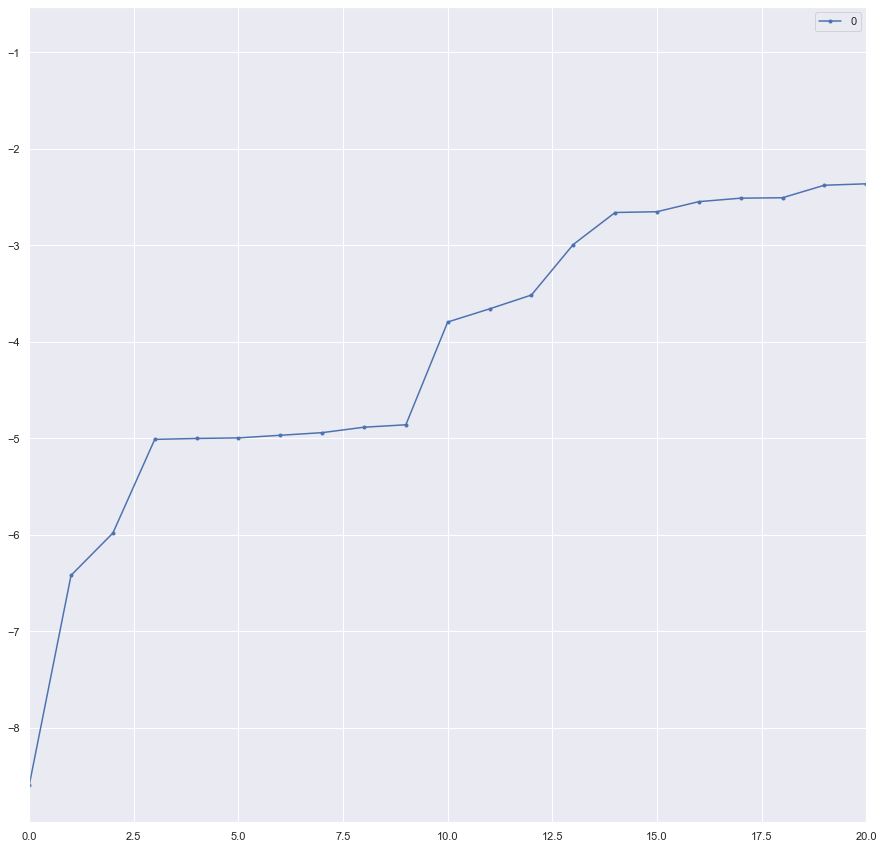

In [55]:
df_scores = clf.negative_outlier_factor_
sorted_df_scores = np.sort(df_scores)
scores = pd.DataFrame(sorted_df_scores)
scores.plot(stacked=True, xlim=[0, 20], style='.-')
plt.show()

In [56]:
scores.head(20)

,0
0,-8.593221
1,-6.418967
2,-5.980949
3,-5.010659
4,-5.000959
5,-4.995111
6,-4.967987
7,-4.940862
8,-4.884457
9,-4.859490


In [57]:
th = sorted_df_scores[10]
th

-3.794872031482323

In [58]:
df.describe([0.01, 0.05, 0.75, 0.90, 0.99]).T

,count,mean,std,min,1%,5%,50%,75%,90%,99%,max
SENIORCITIZEN,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,0.00,1.00,1.000,1.00
TENURE,7043.0,32.371149,24.559481,0.00,1.0,1.00,29.00,55.00,69.00,72.000,72.00
MONTHLYCHARGES,7043.0,64.761692,30.090047,18.25,19.2,19.65,70.35,89.85,102.60,114.729,118.75
TOTALCHARGES,7043.0,2283.300441,2265.000258,18.80,19.9,49.65,1400.55,3786.60,5973.69,8039.256,8684.80
CHURN,7043.0,0.000000,0.000000,0.00,0.0,0.00,0.00,0.00,0.00,0.000,0.00


In [60]:
df[df_scores < th].shape

(10, 21)

In [61]:
df[df_scores < th].index

Int64Index([0, 20, 180, 252, 900, 1282, 3753, 3902, 4290, 6080], dtype='int64')

In [62]:
df.drop(axis=0, labels=df[df_scores < th].index, inplace=True)

## TASK 9

## TASK 10


In [63]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [64]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]
binary_cols

['GENDER',
 'SENIORCITIZEN',
 'PARTNER',
 'DEPENDENTS',
 'PHONESERVICE',
 'PAPERLESSBILLING']

In [65]:
for col in binary_cols:
    label_encoder(df, col)

In [66]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [67]:
rare_analyser(df, "CHURN", cat_cols)

GENDER : 2
   COUNT     RATIO  TARGET_MEAN
0   3483  0.495237          0.0
1   3550  0.504763          0.0


PARTNER : 2
   COUNT     RATIO  TARGET_MEAN
0   3634  0.516707          0.0
1   3399  0.483293          0.0


DEPENDENTS : 2
   COUNT     RATIO  TARGET_MEAN
0   4924  0.700128          0.0
1   2109  0.299872          0.0


PHONESERVICE : 2
   COUNT     RATIO  TARGET_MEAN
0    674  0.095834          0.0
1   6359  0.904166          0.0


MULTIPLELINES : 3
                  COUNT     RATIO  TARGET_MEAN
No                 3388  0.481729          0.0
No phone service    674  0.095834          0.0
Yes                2971  0.422437          0.0


INTERNETSERVICE : 3
             COUNT     RATIO  TARGET_MEAN
DSL           2412  0.342955          0.0
Fiber optic   3096  0.440210          0.0
No            1525  0.216835          0.0


ONLINESECURITY : 3
                     COUNT     RATIO  TARGET_MEAN
No                    3491  0.496374          0.0
No internet service   1525  0.216835

In [68]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [69]:
df = rare_encoder(df, 0.01)

In [70]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [71]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

In [72]:
ohe_cols

['MULTIPLELINES',
 'INTERNETSERVICE',
 'ONLINESECURITY',
 'ONLINEBACKUP',
 'DEVICEPROTECTION',
 'TECHSUPPORT',
 'STREAMINGTV',
 'STREAMINGMOVIES',
 'CONTRACT',
 'PAYMENTMETHOD']

In [73]:
df['TOTALCHARGES'].isnull().any()

False

In [74]:
df = one_hot_encoder(df, ohe_cols)

In [75]:
df.head()

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,PAPERLESSBILLING,MONTHLYCHARGES,TOTALCHARGES,...,TECHSUPPORT_Yes,STREAMINGTV_No internet service,STREAMINGTV_Yes,STREAMINGMOVIES_No internet service,STREAMINGMOVIES_Yes,CONTRACT_One year,CONTRACT_Two year,PAYMENTMETHOD_Credit card (automatic),PAYMENTMETHOD_Electronic check,PAYMENTMETHOD_Mailed check
1,Rare,1,0,0,0,34,1,0,56.95,1889.50,...,0,0,0,0,0,1,0,0,0,1
2,Rare,1,0,0,0,2,1,1,53.85,108.15,...,0,0,0,0,0,0,0,0,0,1
3,Rare,1,0,0,0,45,0,0,42.30,1840.75,...,1,0,0,0,0,1,0,0,0,0
4,Rare,0,0,0,0,2,1,1,70.70,151.65,...,0,0,0,0,0,0,0,0,1,0
5,Rare,0,0,0,0,8,1,1,99.65,820.50,...,0,0,1,0,1,0,0,0,1,0


In [76]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7033
Variables: 32
cat_cols: 29
num_cols: 3
cat_but_car: 0
num_but_cat: 28


## TASK 11

In [77]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [78]:
df[num_cols].head()

,TENURE,MONTHLYCHARGES,TOTALCHARGES
1,0.064545,-0.261052,-0.175285
2,-1.239085,-0.364092,-0.961801
3,0.512668,-0.747997,-0.196809
4,-1.239085,0.195978,-0.942594
5,-0.994654,1.158234,-0.647278


In [79]:
df.columns

Index(['CUSTOMERID', 'GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS',
       'TENURE', 'PHONESERVICE', 'PAPERLESSBILLING', 'MONTHLYCHARGES',
       'TOTALCHARGES', 'CHURN', 'MULTIPLELINES_No phone service',
       'MULTIPLELINES_Yes', 'INTERNETSERVICE_Fiber optic',
       'INTERNETSERVICE_No', 'ONLINESECURITY_No internet service',
       'ONLINESECURITY_Yes', 'ONLINEBACKUP_No internet service',
       'ONLINEBACKUP_Yes', 'DEVICEPROTECTION_No internet service',
       'DEVICEPROTECTION_Yes', 'TECHSUPPORT_No internet service',
       'TECHSUPPORT_Yes', 'STREAMINGTV_No internet service', 'STREAMINGTV_Yes',
       'STREAMINGMOVIES_No internet service', 'STREAMINGMOVIES_Yes',
       'CONTRACT_One year', 'CONTRACT_Two year',
       'PAYMENTMETHOD_Credit card (automatic)',
       'PAYMENTMETHOD_Electronic check', 'PAYMENTMETHOD_Mailed check'],
      dtype='object')

In [80]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7033
Variables: 32
cat_cols: 29
num_cols: 3
cat_but_car: 0
num_but_cat: 28


In [81]:
df['TOTALCHARGES'].isnull().any()

False

In [82]:
df['TOTALCHARGES'].head()

1   -0.175285
2   -0.961801
3   -0.196809
4   -0.942594
5   -0.647278
Name: TOTALCHARGES, dtype: float64

## TASK 12

In [87]:
y = df["CHURN"]
X = df.drop(['CHURN', 'CUSTOMERID'], axis=1)

In [88]:
X

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,PAPERLESSBILLING,MONTHLYCHARGES,TOTALCHARGES,MULTIPLELINES_No phone service,...,TECHSUPPORT_Yes,STREAMINGTV_No internet service,STREAMINGTV_Yes,STREAMINGMOVIES_No internet service,STREAMINGMOVIES_Yes,CONTRACT_One year,CONTRACT_Two year,PAYMENTMETHOD_Credit card (automatic),PAYMENTMETHOD_Electronic check,PAYMENTMETHOD_Mailed check
1,1,0,0,0,0.064545,1,0,-0.261052,-0.175285,0,...,0,0,0,0,0,1,0,0,0,1
2,1,0,0,0,-1.239085,1,1,-0.364092,-0.961801,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0.512668,0,0,-0.747997,-0.196809,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,-1.239085,1,1,0.195978,-0.942594,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,-0.994654,1,1,1.158234,-0.647278,0,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,-0.342839,1,1,0.664641,-0.130691,0,...,1,0,1,0,1,1,0,0,0,1
7039,0,0,1,1,1.612606,1,1,1.276231,2.241375,0,...,0,0,1,0,1,1,0,1,0,0
7040,0,0,1,1,-0.872439,0,1,-1.170126,-0.856585,1,...,0,0,0,0,0,0,0,0,1,0
7041,1,1,1,0,-1.157608,1,1,0.318961,-0.874180,0,...,0,0,0,0,0,0,0,0,0,1


In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [90]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)

In [91]:
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

1.0